### This notebook looks at the number of papers each individual author publishes.

It compares the probability of female and male authors to be among the top 10, 30, 100... most productive authors (both first and last authors).

As input data it uses the records in directory author_allgenders.

We can conclude here that men are generally more strongly represented among highly productive authors. This can be seen because the overall female quota of first authors, for example, is around 25 %, but it is only around 15 % among the most prolifically publishing authors. 

That this pattern appears both for first and for last authors means that there are structural factors that hold female seismologists back from publishing as much as their male colleagues.

In the case of the first authors, this may be an illustration of the leaky pipeline. The frequency of female authors stabilizes at a number of papers per author of 2 over the past ten years. It may be hypothesized that these are papers by graduate students who left academia after their PhD. This indicates that the number of female seismologists in permanent positions is well below 25 %.

For the last authors, it should be taken into account that female faculty are on the rise. Therefore, it is likely that female seismologists are more frequently young faculty that have taken up their appointments in recent years and have not yet had the possibility to publish senior-author papers as much as their male peers. However, there are thousands of last-authored papers by female seismologist authors that have only published one paper during the past ten years. These are unlikely to be the senior-authored works by supervising female faculty, and more likely to be contributions where the last author is simply a contributor.


In [1]:
# install the follwoing packages in the enviroment:
# python3 -m pip install pandas
# python3 -m pip install seaborn

import pandas as pd
#import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
import json

import os

from read_jsondata import read_jsons

import time

In [7]:
# Define local paths

root = "/home/laura/Dropbox/inverts"#! pwd; #root = root[0]
RAW_DIR=root+"/author_allgenders/"  

if not os.path.exists(RAW_DIR):
    print("The directory {} does not exist.\nThere is no raw data for statistical analysis.".format(RAW_DIR))

#### READ DATAFRAME

In [8]:
df = read_jsons(RAW_DIR, columns=['journal','all_names', 'all_genders','all_percent','year'])
# I included cleaning names of journals and removing 2021 data into read_jsons
# and also that impact factor is added
df


,all_names,year,journal,all_genders,all_percent,IF
0,"[Xibin Tan, Xiwei Xu, Renqi Lu]",2017,JGR,"[male, male, male]","[0.86, 0.75, 1.0]",4.191
1,"[Philipp Prasse, James Wookey, J.-Michael Kend...",2020,GJI,"[male, male, male, male, male]","[1.0, 0.99, 0.7035204923384931, 0.99, 0.98]",2.834
2,"[Stephen Glenn Mosher, Pascal Audet]",2017,BSSA,"[male, male]","[0.99, 0.99]",2.274
3,"[Pan Zhang, Ru-Shan Wu, Liguo Han]",2018,GEOPH.,"[male, male, male]","[0.73, 0.6238854410915023, 1.0]",3.093
4,"[Giacomo Pozzi, Nicola De Paola, Robert E. Hol...",2019,EPSL,"[male, male, male, male, male, male]","[0.99, 0.85, 0.99, 0.98, 0.98, 0.99]",4.823
...,...,...,...,...,...,...
20103,"[Toshiro Tanimoto, Anne Valovcin]",2015,JGR,"[male, female]","[0.99, 0.97]",4.191
20104,[Pradeep Talwani],2014,SRL,[male],[0.99],3.131
20105,"[Maurice Lamontagne, Garry Rogers, John Cassid...",2018,BSSA,"[male, male, male, male, male]","[0.98, 0.98, 0.99, 0.98, 0.98]",2.274
20106,"[Jose M. Moratalla, Tatiana Goded, David A. Rh...",2020,SRL,"[male, female, male, female, male]","[0.98, 0.98, 0.99, 0.99, 1.0]",3.131


##### Create new columns for statistics

In [9]:
# First author's gender and percentage:

df['First_Author'] = df['all_names'].apply(lambda x: x[0]) #take the first element of the list all_genders
df['First_Author_gend'] = df['all_genders'].apply(lambda x: x[0]) #take the first element of the list all_genders
df['First_Author_gendprob'] = df['all_percent'].apply(lambda x: x[0]) #take the first element of the list all_genders



# Last author's gender and percentage:

df['Last_Author'] = df['all_names'].apply(lambda x: x[-1]) #take the last element of the list all_genders
df['Last_Author_gend'] = df['all_genders'].apply(lambda x: x[-1]) #take the last element of the list all_genders
df['Last_Author_gendprob'] = df['all_percent'].apply(lambda x: x[-1]) #take the last element of the list all_genders

df

,all_names,year,journal,all_genders,all_percent,IF,First_Author,First_Author_gend,First_Author_gendprob,Last_Author,Last_Author_gend,Last_Author_gendprob
0,"[Xibin Tan, Xiwei Xu, Renqi Lu]",2017,JGR,"[male, male, male]","[0.86, 0.75, 1.0]",4.191,Xibin Tan,male,0.86,Renqi Lu,male,1.00
1,"[Philipp Prasse, James Wookey, J.-Michael Kend...",2020,GJI,"[male, male, male, male, male]","[1.0, 0.99, 0.7035204923384931, 0.99, 0.98]",2.834,Philipp Prasse,male,1.00,Martin Dutko,male,0.98
2,"[Stephen Glenn Mosher, Pascal Audet]",2017,BSSA,"[male, male]","[0.99, 0.99]",2.274,Stephen Glenn Mosher,male,0.99,Pascal Audet,male,0.99
3,"[Pan Zhang, Ru-Shan Wu, Liguo Han]",2018,GEOPH.,"[male, male, male]","[0.73, 0.6238854410915023, 1.0]",3.093,Pan Zhang,male,0.73,Liguo Han,male,1.00
4,"[Giacomo Pozzi, Nicola De Paola, Robert E. Hol...",2019,EPSL,"[male, male, male, male, male, male]","[0.99, 0.85, 0.99, 0.98, 0.98, 0.99]",4.823,Giacomo Pozzi,male,0.99,Edward D. Dempsey,male,0.99
...,...,...,...,...,...,...,...,...,...,...,...,...
20103,"[Toshiro Tanimoto, Anne Valovcin]",2015,JGR,"[male, female]","[0.99, 0.97]",4.191,Toshiro Tanimoto,male,0.99,Anne Valovcin,female,0.97
20104,[Pradeep Talwani],2014,SRL,[male],[0.99],3.131,Pradeep Talwani,male,0.99,Pradeep Talwani,male,0.99
20105,"[Maurice Lamontagne, Garry Rogers, John Cassid...",2018,BSSA,"[male, male, male, male, male]","[0.98, 0.98, 0.99, 0.98, 0.98]",2.274,Maurice Lamontagne,male,0.98,Martin S. Lawrence,male,0.98
20106,"[Jose M. Moratalla, Tatiana Goded, David A. Rh...",2020,SRL,"[male, female, male, female, male]","[0.98, 0.98, 0.99, 0.99, 1.0]",3.131,Jose M. Moratalla,male,0.98,Matthew C. Gerstenberger,male,1.00


##### Clean names just in case

In [10]:
def Clean_names(x):
    first_name = x.split()[0] 
    last_name = x.split()[-1]
    
    name = first_name + ' ' + last_name
    
    return name


df['First_Author_clean'] = df['First_Author'].apply(lambda x: Clean_names(x))
df['Last_Author_clean'] = df['Last_Author'].apply(lambda x: Clean_names(x))

df.drop(columns=['First_Author', 'Last_Author'],inplace = True)
df

,all_names,year,journal,all_genders,all_percent,IF,First_Author_gend,First_Author_gendprob,Last_Author_gend,Last_Author_gendprob,First_Author_clean,Last_Author_clean
0,"[Xibin Tan, Xiwei Xu, Renqi Lu]",2017,JGR,"[male, male, male]","[0.86, 0.75, 1.0]",4.191,male,0.86,male,1.00,Xibin Tan,Renqi Lu
1,"[Philipp Prasse, James Wookey, J.-Michael Kend...",2020,GJI,"[male, male, male, male, male]","[1.0, 0.99, 0.7035204923384931, 0.99, 0.98]",2.834,male,1.00,male,0.98,Philipp Prasse,Martin Dutko
2,"[Stephen Glenn Mosher, Pascal Audet]",2017,BSSA,"[male, male]","[0.99, 0.99]",2.274,male,0.99,male,0.99,Stephen Mosher,Pascal Audet
3,"[Pan Zhang, Ru-Shan Wu, Liguo Han]",2018,GEOPH.,"[male, male, male]","[0.73, 0.6238854410915023, 1.0]",3.093,male,0.73,male,1.00,Pan Zhang,Liguo Han
4,"[Giacomo Pozzi, Nicola De Paola, Robert E. Hol...",2019,EPSL,"[male, male, male, male, male, male]","[0.99, 0.85, 0.99, 0.98, 0.98, 0.99]",4.823,male,0.99,male,0.99,Giacomo Pozzi,Edward Dempsey
...,...,...,...,...,...,...,...,...,...,...,...,...
20103,"[Toshiro Tanimoto, Anne Valovcin]",2015,JGR,"[male, female]","[0.99, 0.97]",4.191,male,0.99,female,0.97,Toshiro Tanimoto,Anne Valovcin
20104,[Pradeep Talwani],2014,SRL,[male],[0.99],3.131,male,0.99,male,0.99,Pradeep Talwani,Pradeep Talwani
20105,"[Maurice Lamontagne, Garry Rogers, John Cassid...",2018,BSSA,"[male, male, male, male, male]","[0.98, 0.98, 0.99, 0.98, 0.98]",2.274,male,0.98,male,0.98,Maurice Lamontagne,Martin Lawrence
20106,"[Jose M. Moratalla, Tatiana Goded, David A. Rh...",2020,SRL,"[male, female, male, female, male]","[0.98, 0.98, 0.99, 0.99, 1.0]",3.131,male,0.98,male,1.00,Jose Moratalla,Matthew Gerstenberger


In [11]:
### Count number of papers for each author and create dictionary

dict_last = df.Last_Author_clean.value_counts().to_dict()
dict_first = df.First_Author_clean.value_counts().to_dict()

In [12]:
### Create new dataframes, one for first authors and another one for last authors

df_first = df[['First_Author_clean','First_Author_gend','First_Author_gendprob', 'year']].copy()
df_last = df[['Last_Author_clean','Last_Author_gend','Last_Author_gendprob', 'year']].copy()

df_first['Num_papers'] = df_first.First_Author_clean.map(dict_first) # create new column with number of papers
df_last['Num_papers'] = df_last.Last_Author_clean.map(dict_last)

In [13]:
### Drop duplicated name and sort in descending order of num_papers

df_first2 = df_first.drop_duplicates('First_Author_clean').sort_values(by=['Num_papers'],ascending=False).reset_index(drop = True)

df_last2 = df_last.drop_duplicates('Last_Author_clean').sort_values(by=['Num_papers'],ascending=False).reset_index(drop = True)

df_first2[0:50]

,First_Author_clean,First_Author_gend,First_Author_gendprob,year,Num_papers
0,Yangkang Chen,male,1.000000,2015,28
1,Fred Pollitz,male,0.960000,2015,27
2,Norman Sleep,male,0.990000,2015,24
3,Gail Atkinson,female,0.940000,2015,24
4,Diego Melgar,male,0.990000,2016,23
5,Thorne Lay,male,0.970000,2016,22
6,Ivan Koulakov,male,0.990000,2013,21
7,Susan Hough,female,0.980000,2020,20
8,Xin Liu,female,0.520000,2016,18
9,Xinming Wu,male,0.780000,2017,18


In [14]:
## It is easier to have all probabilities with respect to female

# prob(female) = 1 - prob(male)

# Prob first author female:

df_first2['First_Author_probF'] = df_first2['First_Author_gendprob']

df_first2.loc[df_first2['First_Author_gend'] == 'male','First_Author_probF'] = \
    1 - df_first2.loc[df_first2['First_Author_gend'] == 'male','First_Author_probF']

# Prob last author female:

df_last2['Last_Author_probF'] = df_last2['Last_Author_gendprob']

df_last2.loc[df_last2['Last_Author_gend'] == 'male','Last_Author_probF'] = \
    1 - df_last2.loc[df_last2['Last_Author_gend'] == 'male','Last_Author_probF']


In [15]:
print('Probability female on top 30 first authors', df_first2.loc[0:30,'First_Author_probF'].sum()/30) # last index is not included!!
print('Probability female on top 10 first authors', df_first2.loc[0:10,'First_Author_probF'].sum()/10)
print("\n")
# NOTE. Xin Liu is misclassified. I think is a postdoc in stanford, and he's a guy
# there is another Xin Liu in seismology in China, another man. Their articles appear combined, as their names are identical.
print('Probability female on top 10 first authors when binary gender', df_first2.loc[0:10,'First_Author_probF'].round().sum()/10)
print('Probability female on top 20 first authors when binary gender', df_first2.loc[0:20,'First_Author_probF'].round().sum()/20)
print('Probability female on top 30 first authors when binary gender', df_first2.loc[0:30,'First_Author_probF'].round().sum()/30)
print('Probability female on top 40 first authors when binary gender', df_first2.loc[0:40,'First_Author_probF'].round().sum()/40)
print('Probability female on top 50 first authors when binary gender', df_first2.loc[0:50,'First_Author_probF'].round().sum()/50)
print('Probability female on top 100 first authors when binary gender', df_first2.loc[0:100,'First_Author_probF'].round().sum()/100)
print('Probability female on top 1000 first authors when binary gender', df_first2.loc[0:1000,'First_Author_probF'].round().sum()/1000)
print('Probability female on top 2000 first authors when binary gender', df_first2.loc[0:2000,'First_Author_probF'].round().sum()/2000)
print('Probability female on top 10000 first authors when binary gender', df_first2.loc[0:10000,'First_Author_probF'].round().sum()/10000)
# df_first2.iloc[0:30]


Probability female on top 30 first authors 0.15970762355600082
Probability female on top 10 first authors 0.3081228706680025


Probability female on top 10 first authors when binary gender 0.3
Probability female on top 20 first authors when binary gender 0.15
Probability female on top 30 first authors when binary gender 0.13333333333333333
Probability female on top 40 first authors when binary gender 0.125
Probability female on top 50 first authors when binary gender 0.12
Probability female on top 100 first authors when binary gender 0.12
Probability female on top 1000 first authors when binary gender 0.212
Probability female on top 2000 first authors when binary gender 0.2415
Probability female on top 10000 first authors when binary gender 0.246


0.26247177171012115 0.2905888118561881 0.7298296037774584 0.7094111881438118


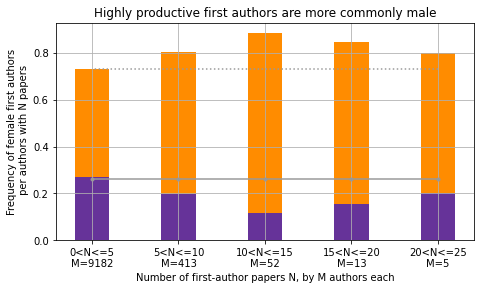

[1.0, 1.0, 1.0000000000000002, 1.0000000000000002, 1.0]


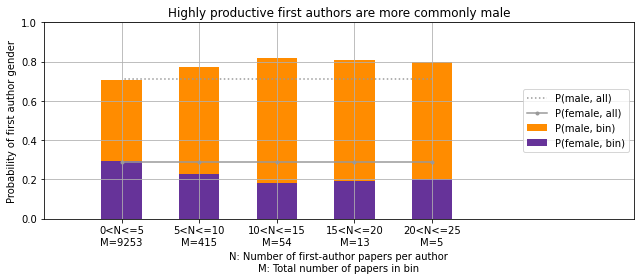

In [16]:
prob_f_in_n = []
prob_m_in_n = []
as_per_n = []
ns = []
plt.figure(figsize=(7.5, 4))
# ns = np.arange(50, 5000, 10)

# drop rows where the gender probability is exactly 0.5 for this case
df_first2 = df_first2[df_first2["First_Author_gend"] != "init"].reset_index(drop=True)

p_all_female_first = len(np.where(df_first2.First_Author_probF > 0.5)[0]) / len(df_first2)
p_all_female_first_proba = df_first2.First_Author_probF.mean()
p_all_male_first = len(np.where(df_first2.First_Author_probF < 0.5)[0]) / len(df_first2)
p_all_male_first_proba = (1. - df_first2.First_Author_probF).mean()

print(p_all_female_first, p_all_female_first_proba, p_all_male_first, p_all_male_first_proba)

# one-by-one:
# n = df_first2.Num_papers.max()
# while n > 0: # df_first.Num_papers.max():
#     df_part = df_first2[df_first2.Num_papers == n]
#     prob_f_in_n.append(df_part['First_Author_probF'].round().mean())
#     prob_m_in_n.append((1. - df_part['First_Author_probF']).round().mean())
#     as_per_n.append(len(df_part))
#     ns.append(n)
#     n -= 1

# in larger bins:
n = 25 #df_first2.Num_papers.max()
binstep = 5
while n >= binstep: # df_first.Num_papers.max():
    df_part = df_first2[df_first2.Num_papers > (n- binstep)]
    df_part = df_part[df_part["First_Author_probF"] != 0.5].reset_index(drop=True)
    df_part = df_part[df_part.Num_papers <= n]
    prob_f_in_n.append(df_part['First_Author_probF'].round().mean())
    prob_m_in_n.append((1. - df_part['First_Author_probF']).round().mean())
    as_per_n.append(len(df_part))
    ns.append(n)
    n -= binstep

plt.bar(ns, np.array(prob_m_in_n) / (np.array(prob_f_in_n) + np.array(prob_m_in_n)), width=2, color="darkorange")
plt.bar(ns, np.array(prob_f_in_n) / (np.array(prob_f_in_n) + np.array(prob_m_in_n)), width=2, color="rebeccapurple")
plt.ylabel("Frequency of female first authors\n per authors with N papers")
plt.xlabel("Number of first-author papers N, by M authors each")
plt.title("Highly productive first authors are more commonly male")
plt.grid()
plt.xticks(ns,
           ["{}<N<={}\nM={}".format(ns[i]-binstep, ns[i], as_per_n[i]) for i in range(len(ns))])
plt.plot(ns, np.ones(len(ns)) * p_all_male_first, ":", color="0.6",)
plt.plot(ns, np.ones(len(ns)) * p_all_female_first, ".-", color="0.6",)
plt.savefig("most_productive_first_binned_{}.png".format(binstep), dpi=300)

plt.show()


# probabilistically:
prob_f_in_n = []
prob_m_in_n = []
as_per_n = []
ns = []
plt.figure(figsize=(9, 4))
# in larger bins:
n = 25 #df_first2.Num_papers.max()
binstep = 5
while n >= binstep: # df_first.Num_papers.max():
    df_part = df_first2[df_first2.Num_papers > (n - binstep)]
    df_part = df_part[df_part.Num_papers <= n]
    prob_f_in_n.append(df_part['First_Author_probF'].mean())
    prob_m_in_n.append((1. - df_part['First_Author_probF']).mean())
    as_per_n.append(len(df_part))
    ns.append(n)
    n -= binstep
print([prob_f_in_n[ii] + prob_m_in_n[ii] for ii in range(len(prob_f_in_n))])
#plt.plot(ns, np.array(prob_m_in_n) + np.array(prob_f_in_n))#, width=2.5)

plt.bar(ns, np.array(prob_m_in_n), width=2.6, color="darkorange")
plt.bar(ns, np.array(prob_f_in_n), width=2.6, color="rebeccapurple")
plt.ylabel("Probability of first author gender")
plt.xlabel("N: Number of first-author papers per author\nM: Total number of papers in bin")
plt.title("Highly productive first authors are more commonly male")
plt.grid()
plt.xticks(ns,
           ["{}<N<={}\nM={}".format(ns[i]-binstep, ns[i], as_per_n[i]) for i in range(len(ns))])
plt.plot(ns, np.ones(len(ns)) * p_all_male_first_proba, ":", color="0.6",)
plt.plot(ns, np.ones(len(ns)) * p_all_female_first_proba, ".-", color="0.6",)
plt.legend([ "P(male, all)", "P(female, all)", "P(male, bin)", "P(female, bin)",], loc=5)
plt.ylim(0, 1)
plt.xlim(0, 38)
plt.tight_layout()
plt.savefig("most_productive_first_binned_{}_proba.png".format(binstep), dpi=300)

plt.show()

In [17]:
print('Probability female on top 30 last authors', df_last2.loc[0:29,'Last_Author_probF'].sum()/30)
print('Probability female on top 10 last authors', df_last2.loc[0:9,'Last_Author_probF'].sum()/10)


df_last2.iloc[0:50,:]

Probability female on top 30 last authors 0.09333333333333332
Probability female on top 10 last authors 0.242


,Last_Author_clean,Last_Author_gend,Last_Author_gendprob,year,Num_papers,Last_Author_probF
0,Peter Shearer,male,0.99,2017,47,0.01
1,Gregory Beroza,male,0.99,2018,41,0.01
2,Xiaofei Chen,male,0.57,2018,41,0.43
3,Stefan Wiemer,male,0.98,2011,40,0.02
4,Gail Atkinson,female,0.94,2017,39,0.94
5,Barbara Romanowicz,female,0.98,2018,38,0.98
6,Roland Bürgmann,male,0.99,2013,38,0.01
7,Yangkang Chen,male,1.00,2020,38,0.00
8,Yehuda Ben‐Zion,male,1.00,2016,37,0.00
9,Tariq Alkhalifah,male,0.98,2010,35,0.02


9505
9505
25
[25, 20, 15, 10, 5]
[0.1, 0.10204081632653061, 0.1111111111111111, 0.14430379746835442, 0.1974306144709732]


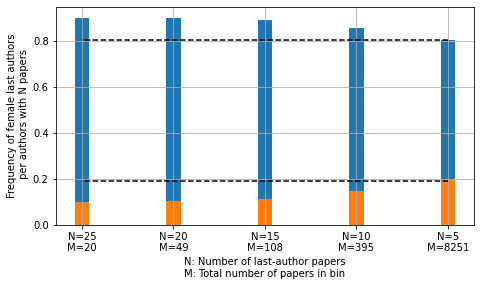

[1.0, 1.0, 1.0000000000000002, 1.0, 1.0]


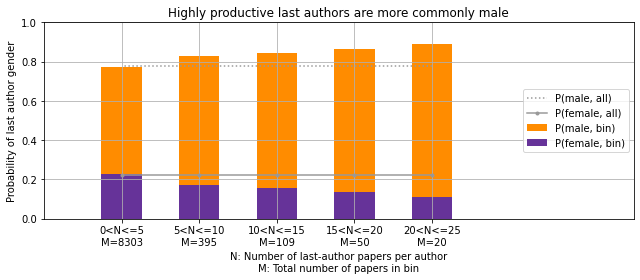

In [18]:
# prob_f_in_n = []
# prob_m_in_n = []
# ns = np.arange(50, 7000, 10)
# ps_per_a = []
# n_before = 0

# # drop rows where the gender probability is exactly 0.5 for this case
# print(len(df_last2))
# df_last2 = df_last2[df_last2["Last_Author_probF"] != 0.5].reset_index(drop=True)
# print(len(df_last2))

# for n in ns:
#     prob_f_in_n.append(df_last2.loc[0:n,'Last_Author_probF'].round().sum()/n)
#     prob_m_in_n.append((1. - df_last2.loc[0:n,'Last_Author_probF']).round().sum()/n)
#     ps_per_a.append(df_last2.loc[n,'Num_papers'])
#     n_before = n
# plt.plot(ns, prob_f_in_n)
# plt.plot(ns, prob_m_in_n)
# plt.ylabel("Frequency of gender of last author\n out of N most productive authors")
# plt.xlabel("Nr of last-authored papers")
# plt.legend(["Female", "Male"])
# plt.title("Senior authors are more commonly male")
# plt.grid()
# plt.xticks([50, 1050, 2050, 3050, 4050],
#            [ps_per_a[0], ps_per_a[100], ps_per_a[200],
#             ps_per_a[300], ps_per_a[400]])
# plt.show()

# plt.plot(ns, np.array(prob_f_in_n) / (np.array(prob_f_in_n) + np.array(prob_m_in_n)))
# plt.ylabel("Frequency of female last authors\n among N most productive last authors")
# plt.xlabel("The N most productive authors with M papers each")
# #plt.legend(["Female", "Male"])
# plt.title("Senior authors are more commonly male")
# plt.grid()
# plt.xticks([50, 1050, 2050, 3050, 4050, 5050 , 6050],
#            ["N={}\nM={}".format(50, ps_per_a[0]),
#             "N={}\nM={}".format(1050, ps_per_a[100]),
#             "N={}\nM={}".format(2050, ps_per_a[200]),
#             "N={}\nM={}".format(3050, ps_per_a[300]),
#             "N={}\nM={}".format(4050, ps_per_a[400]),
#             "N={}\nM={}".format(5050, ps_per_a[500]),
#             "N={}\nM={}".format(6050, ps_per_a[600]),
#             ])
# plt.savefig("most_productive_last.png", dpi=300)

# plt.show()


prob_f_in_n = []
prob_m_in_n = []
as_per_n = []
ns = []
plt.figure(figsize=(7.5, 4))
# ns = np.arange(50, 5000, 10)

# drop rows where the gender probability is exactly 0.5 for this case
print(len(df_last2))
print(len(df_last2))
df_last2 = df_last2[df_last2["Last_Author_gend"] != "init"].reset_index(drop=True)

p_all_female_last = len(np.where(df_last2.Last_Author_probF > 0.5)[0]) / len(df_last2)
p_all_male_last = len(np.where(df_last2.Last_Author_probF < 0.5)[0]) / len(df_last2)
p_all_female_last_proba = df_last2.Last_Author_probF.mean()
p_all_male_last_proba = (1. - df_last2.Last_Author_probF).mean()

# one-by-one
# n = 1 #df_first2.Num_papers.max()
# while n < df_first.Num_papers.max():
#     df_part = df_last2[df_last2.Num_papers == n]
#     prob_f_in_n.append(df_part['Last_Author_probF'].round().mean())
#     prob_m_in_n.append((1. - df_part['Last_Author_probF']).round().mean())
#     as_per_n.append(len(df_part))
#     ns.append(n)
#     n += 1
    
n = 25 #df_last2.Num_papers.max()
print(n)
binstep = 5
while n >= binstep: # df_first.Num_papers.max():
    df_part = df_last2[df_last2.Num_papers > (n- binstep)]
    df_part = df_part[df_part["Last_Author_probF"] != 0.5].reset_index(drop=True)

    df_part = df_part[df_part.Num_papers <= n]
    prob_f_in_n.append(df_part['Last_Author_probF'].round().mean())
    prob_m_in_n.append((1. - df_part['Last_Author_probF']).round().mean())
    as_per_n.append(len(df_part))
    ns.append(n)
    n -= binstep
print(ns)
print(prob_f_in_n)
plt.bar(ns[::-1],np.array(prob_m_in_n) / (np.array(prob_f_in_n) + np.array(prob_m_in_n)) )
plt.bar(ns[::-1], np.array(prob_f_in_n) / (np.array(prob_f_in_n) + np.array(prob_m_in_n)))
plt.ylabel("Frequency of female last authors\n per authors with N papers")
plt.xlabel("N: Number of last-author papers\nM: Total number of papers in bin")

# plt.title("Highly productive first authors are more commonly male")
plt.grid()
plt.xticks(ns[::-1],
           ["N={}\nM={}".format(ns[i], as_per_n[i]) for i in range(len(ns))])
#plt.savefig("most_productive_first.png", dpi=300)
plt.plot(ns, np.ones(len(ns)) * p_all_female_last, "k--")
plt.plot(ns, np.ones(len(ns)) * p_all_male_last, "k--")

plt.show()


# probabilistically:
prob_f_in_n = []
prob_m_in_n = []
as_per_n = []
ns = []
plt.figure(figsize=(9, 4))
# in larger bins:
n = 25 #df_first2.Num_papers.max()
binstep = 5
while n >= binstep: # df_first.Num_papers.max():
    df_part = df_last2[df_last2.Num_papers > (n - binstep)]
    df_part = df_part[df_part.Num_papers <= n]
    prob_f_in_n.append(df_part['Last_Author_probF'].mean())
    prob_m_in_n.append((1. - df_part['Last_Author_probF']).mean())
    as_per_n.append(len(df_part))
    ns.append(n)
    n -= binstep
print([prob_f_in_n[ii] + prob_m_in_n[ii] for ii in range(len(prob_f_in_n))])
#plt.plot(ns, np.array(prob_m_in_n) + np.array(prob_f_in_n))#, width=2.5)
plt.bar(ns, np.array(prob_m_in_n), width=2.6, color="darkorange")
plt.bar(ns, np.array(prob_f_in_n), width=2.6, color="rebeccapurple")
plt.ylabel("Probability of last author gender")
plt.xlabel("N: Number of last-author papers per author\nM: Total number of papers in bin")
plt.title("Highly productive last authors are more commonly male")
plt.grid()
plt.xticks(ns,
           ["{}<N<={}\nM={}".format(ns[i]-binstep, ns[i], as_per_n[i]) for i in range(len(ns))])
plt.plot(ns, np.ones(len(ns)) * p_all_male_last_proba, ":", color="0.6",)
plt.plot(ns, np.ones(len(ns)) * p_all_female_last_proba, ".-", color="0.6",)
plt.legend([ "P(male, all)", "P(female, all)", "P(male, bin)", "P(female, bin)",], loc=5)
plt.ylim(0, 1)
plt.xlim(0, 38)
plt.tight_layout()

plt.savefig("most_productive_last_binned_{}_proba.png".format(binstep), dpi=300)

plt.show()

## is it a time lag effect?
If women only started to increase in numbers recently, this could have an effect on their overall number of publications since they had "less time" to accumulate them. 

We could check this by plotting similar graphs to above but sorted by year, I guess?

In [19]:
# to do this we must recreate the above author-ranking after year selection.

In [20]:
#years = np.arange(2010, 2021, 1)
years = [[2010,2015], [2016, 2020]]
f1 = plt.figure(figsize=(12, 6))
ax1 = plt.subplot(111)
leg1 = []

import matplotlib as mpl
import cycler
n = 11
color = plt.cm.Spectral(np.linspace(0, 1, n))
mpl.rcParams['axes.prop_cycle'] = cycler.cycler('color', color)

for yearbin in years:

    print(condi)
    ### Count number of papers for each author and create dictionary
    dict_last = df[df.year in np.an[str(y) for y in yearbin]].Last_Author_clean.value_counts().to_dict()
    dict_first = df[df.year in [str(y) for y in yearbin]].First_Author_clean.value_counts().to_dict()
    ### Create new dataframes, one for first authors and another one for last authors

    df_first_yr = df[['First_Author_clean','First_Author_gend','First_Author_gendprob', 'year']].copy()
    df_first_yr = df_first_yr[df_first_yr.year in [str(y) for y in yearbin]]
    df_last_yr = df[['Last_Author_clean','Last_Author_gend','Last_Author_gendprob', 'year']].copy()
    df_last_yr = df_last_yr[df_last_yr.year in [str(y) for y in yearbin]]

    df_first_yr['Num_papers'] = df_first_yr.First_Author_clean.map(dict_first) # create new column with number of papers
    df_last_yr['Num_papers'] = df_last_yr.Last_Author_clean.map(dict_last)
    
    
    ### Drop duplicated name and sort in descending order of num_papers
    df_first_yr = df_first_yr.drop_duplicates('First_Author_clean').sort_values(by=['Num_papers'],ascending=False).reset_index(drop = True)
    df_last_yr = df_last_yr.drop_duplicates('Last_Author_clean').sort_values(by=['Num_papers'],ascending=False).reset_index(drop = True)

    
    # drop the nans:
    df_first_yr = df_first_yr.dropna().reset_index(drop=True)
    df_last_yr = df_last_yr.dropna().reset_index(drop=True)
    # Prob first author female:

    df_first_yr['First_Author_probF'] = df_first_yr['First_Author_gendprob']
    df_first_yr.loc[df_first_yr['First_Author_gend'] == 'male','First_Author_probF'] = \
        1 - df_first_yr.loc[df_first_yr['First_Author_gend'] == 'male','First_Author_probF']

    # Prob last author female:
    df_last_yr['Last_Author_probF'] = df_last_yr['Last_Author_gendprob']
    df_last_yr.loc[df_last_yr['Last_Author_gend'] == 'male','Last_Author_probF'] = \
        1 - df_last_yr.loc[df_last_yr['Last_Author_gend'] == 'male','Last_Author_probF']
    print(year)
    # display(df_first_yr[0:1])
    # display(df_last_yr[0:1])
    
    prob_f_in_n = []
    prob_m_in_n = []
    ns = []
    as_per_n = []
    # drop rows where the gender probability is exactly 0.5 for this case
    #df_last_yr = df_last_yr[df_last_yr["Last_Author_probF"] != 0.5].reset_index(drop=True)
    #df_last_yr = df_last_yr[df_last_yr["Last_Author_gend"] != "init"].reset_index(drop=True)

    n = 6 #df_last_yr.Num_papers.max()
    binstep=1
    while n > binstep: # df_first.Num_papers.max():
        df_part = df_last_yr[df_last_yr.Num_papers <= n]
        df_part = df_last_yr[df_last_yr.Num_papers > n - binstep]
        
        if len(df_part) > 0:
            prob_f_in_n.append(df_part['Last_Author_probF'].mean())
            prob_m_in_n.append((1. - df_part['Last_Author_probF']).mean())
            as_per_n.append(len(df_part))
            ns.append(n)
        n -= binstep
    print(ns)
    ax1.plot(ns, np.array(prob_f_in_n), "d", markersize=20, alpha=0.5)
    leg1.append("{}-{}, n={}".format(yearbin[0], yearbin[1], len(df_last_yr)))
    
    prob_f_in_n = []
    
ax1.legend(leg1, loc=0, ncol=2)
plt.xticks(ns, ["{}<N<={}\nM={}".format(ns[i]-binstep, ns[i], as_per_n[i]) for i in range(len(ns))])
ax1.grid()

plt.show()

SyntaxError: invalid syntax. Perhaps you forgot a comma? (<ipython-input-20-6e0ae07aa260>, line 17)

2010
[8, 6, 5, 4, 3, 2, 1]
[6, 4, 3, 2, 1]
2011
[8, 7, 6, 5, 4, 3, 2, 1]
[5, 4, 3, 2, 1]
2012
[5, 4, 3, 2, 1]
[6, 4, 3, 2, 1]
2013
[7, 6, 5, 4, 3, 2, 1]
[4, 3, 2, 1]
2014
[7, 6, 5, 4, 3, 2, 1]
[5, 4, 3, 2, 1]
2015
[7, 6, 5, 4, 3, 2, 1]
[4, 3, 2, 1]
2016
[9, 7, 6, 5, 4, 3, 2, 1]
[5, 4, 3, 2, 1]
2017
[7, 6, 5, 4, 3, 2, 1]
[5, 4, 3, 2, 1]
2018
[10, 7, 6, 5, 4, 3, 2, 1]
[5, 4, 3, 2, 1]
2019
[9, 8, 7, 6, 5, 4, 3, 2, 1]
[5, 4, 3, 2, 1]
2020
[9, 8, 7, 6, 5, 4, 3, 2, 1]
[9, 4, 3, 2, 1]


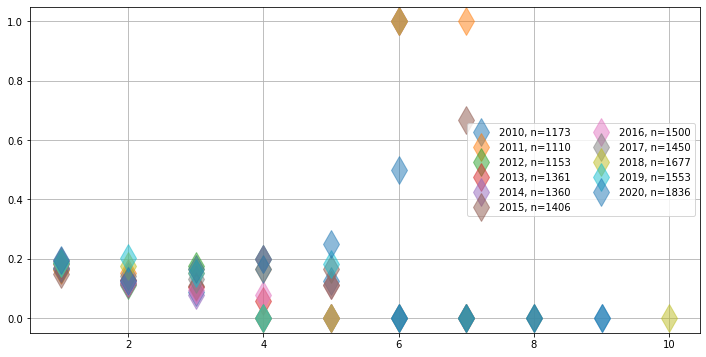

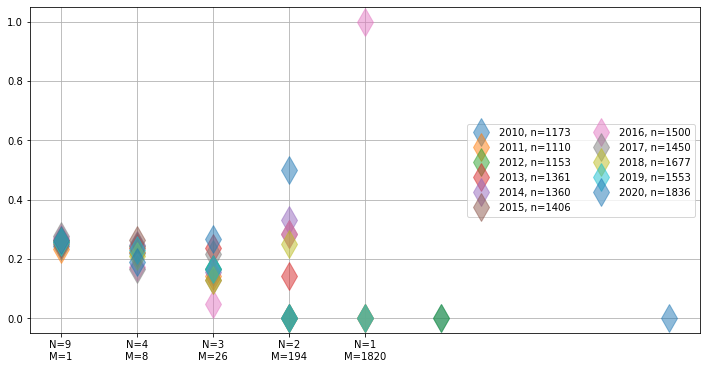

In [21]:
years = np.arange(2010, 2021, 1)
f1 = plt.figure(figsize=(12, 6))
ax1 = plt.subplot(111)
f2 = plt.figure(figsize=(12, 6))
ax2 = plt.subplot(111)
leg2 = []
leg1 = []

import matplotlib as mpl
import cycler
n = 11
color = plt.cm.Spectral(np.linspace(0, 1, n))
mpl.rcParams['axes.prop_cycle'] = cycler.cycler('color', color)

for year in years:
    ### Count number of papers for each author and create dictionary
    dict_last = df[df.year==str(year)].Last_Author_clean.value_counts().to_dict()
    dict_first = df[df.year==str(year)].First_Author_clean.value_counts().to_dict()
    ### Create new dataframes, one for first authors and another one for last authors

    df_first_yr = df[['First_Author_clean','First_Author_gend','First_Author_gendprob', 'year']].copy()
    df_first_yr = df_first_yr[df_first_yr.year == str(year)]
    df_last_yr = df[['Last_Author_clean','Last_Author_gend','Last_Author_gendprob', 'year']].copy()
    df_last_yr = df_last_yr[df_last_yr.year == str(year)]

    df_first_yr['Num_papers'] = df_first_yr.First_Author_clean.map(dict_first) # create new column with number of papers
    df_last_yr['Num_papers'] = df_last_yr.Last_Author_clean.map(dict_last)
    
    
    ### Drop duplicated name and sort in descending order of num_papers
    df_first_yr = df_first_yr.drop_duplicates('First_Author_clean').sort_values(by=['Num_papers'],ascending=False).reset_index(drop = True)
    df_last_yr = df_last_yr.drop_duplicates('Last_Author_clean').sort_values(by=['Num_papers'],ascending=False).reset_index(drop = True)

    
    # drop the nans:
    df_first_yr = df_first_yr.dropna().reset_index(drop=True)
    df_last_yr = df_last_yr.dropna().reset_index(drop=True)
    # Prob first author female:

    df_first_yr['First_Author_probF'] = df_first_yr['First_Author_gendprob']
    df_first_yr.loc[df_first_yr['First_Author_gend'] == 'male','First_Author_probF'] = \
        1 - df_first_yr.loc[df_first_yr['First_Author_gend'] == 'male','First_Author_probF']

    # Prob last author female:
    df_last_yr['Last_Author_probF'] = df_last_yr['Last_Author_gendprob']
    df_last_yr.loc[df_last_yr['Last_Author_gend'] == 'male','Last_Author_probF'] = \
        1 - df_last_yr.loc[df_last_yr['Last_Author_gend'] == 'male','Last_Author_probF']
    print(year)
    # display(df_first_yr[0:1])
    # display(df_last_yr[0:1])
    
    prob_f_in_n = []
    prob_m_in_n = []
    ns = []
    as_per_n = []
    n_before = 0

    # drop rows where the gender probability is exactly 0.5 for this case
    df_last_yr = df_last_yr[df_last_yr["Last_Author_probF"] != 0.5].reset_index(drop=True)
    df_last_yr = df_last_yr[df_last_yr["Last_Author_gend"] != "init"].reset_index(drop=True)

    n = 10 #df_last_yr.Num_papers.max()
    while n > 0: # df_first.Num_papers.max():
        df_part = df_last_yr[df_last_yr.Num_papers == n]
        
        if len(df_part) > 0:
            prob_f_in_n.append(df_part['Last_Author_probF'].round().mean())
            prob_m_in_n.append((1. - df_part['Last_Author_probF']).round().mean())
            as_per_n.append(len(df_part))
            ns.append(n)
        n -= 1
    print(ns)
    ax1.plot(ns, np.array(prob_f_in_n) / (np.array(prob_f_in_n) + np.array(prob_m_in_n)), "d",markersize=20, alpha=0.5)
    leg1.append("{}, n={}".format(year, len(df_last_yr)))
    
    prob_f_in_n = []
    prob_m_in_n = []
    ns = []
    as_per_n = []
    n_before = 0

    # drop rows where the gender probability is exactly 0.5 for this case
    df_first_yr = df_first_yr[df_first_yr["First_Author_probF"] != 0.5].reset_index(drop=True)
    df_first_yr = df_first_yr[df_first_yr["First_Author_gend"] != "init"].reset_index(drop=True)

    n = df_first_yr.Num_papers.max()
    while n > 0: # df_first.Num_papers.max():
        df_part = df_first_yr[df_first_yr.Num_papers == n]
        
        if len(df_part) > 0:
            prob_f_in_n.append(df_part['First_Author_probF'].round().mean())
            prob_m_in_n.append((1. - df_part['First_Author_probF']).round().mean())
            as_per_n.append(len(df_part))
            ns.append(n)
        n -= 1
    print(ns)
    ax2.plot(ns, np.array(prob_f_in_n) / (np.array(prob_f_in_n) + np.array(prob_m_in_n)), "d",markersize=20, alpha=0.5)
    leg2.append("{}, n={}".format(year, len(df_last_yr)))
    
ax1.legend(leg1, loc=5, ncol=2)
plt.gca()
plt.xticks(np.arange(len(ns)) + 1,
           ["N={}\nM={}".format(ns[i], as_per_n[i]) for i in range(len(ns))])
ax2.legend(leg2, loc=5, ncol=2)
ax1.grid()
ax2.grid()

plt.show()

In [32]:
# wanted: probability of unique female authors in this data.

names = []
genders = []
gendprob = []
for i in range(len(df)):
    names.extend(df.iloc[i].all_names)
    genders.extend(df.iloc[i].all_genders)
    gendprob.extend(df.iloc[i].all_percent)

df_expanded = pd.DataFrame(columns=["names", "genders", "gendprob"])
df_expanded["names"] = names
df_expanded["genders"] = genders
df_expanded["gendprob"] = gendprob
df_expanded["probF"] = df_expanded["gendprob"]
df_expanded.loc[df_expanded["genders"] == 'male','probF'] = \
     1 - df_expanded.loc[df_expanded["genders"] == 'male','probF']
df_unique_authors = df_expanded.drop_duplicates('names').reset_index(drop = True)

# dict_all_gender = dict(zip(df_expanded.name, df_expanded.probF))

In [34]:
display(df_unique_authors)
print("The probability of female unique authors is, ", df_unique_authors.probF.mean())

,names,genders,gendprob,probF
0,Xibin Tan,male,0.86,0.14
1,Xiwei Xu,male,0.75,0.25
2,Renqi Lu,male,1.00,0.00
3,Philipp Prasse,male,1.00,0.00
4,James Wookey,male,0.99,0.01
...,...,...,...,...
29855,Takafumi Matsui,male,1.00,0.00
29856,Jamie Ryan,male,0.81,0.19
29857,Jean‐Pierre Tournier,male,0.98,0.02
29858,Martin S. Lawrence,male,0.98,0.02


The probability of female unique authors is,  0.260945178368143


In [42]:
print("The probability of female unique first authors is, ", df_first2.First_Author_probF.mean())

The probability of female unique first authors is,  0.2905888118561881


In [43]:
print("The probability of female unique last authors is, ", df_last2.Last_Author_probF.mean())

The probability of female unique last authors is,  0.22228785602766263


this fits the numbers of She Figures almost too well :-o